## Explore SST Trends

- compare CoRTAD data (T data in UI SST dataset) with ECCO2 SST and ERA5 SST data
- compare period 2002-2021

In [1]:
# import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import glob
import os
import my_functions
import datetime as dt
import statsmodels.api as sm
%matplotlib inline

In [2]:
## import data
os.chdir("/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/")
ECCO2 = xr.open_dataset('ECCO2_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')

In [4]:
ECCO2 = my_functions.add_week_and_month(ECCO2)
ECCO2 = my_functions.calc_meridional_mean(ECCO2, variable = 'SST', lon = 345)
UI_SST = my_functions.calc_meridional_mean(UI_SST, variable = 'Toff15W', lon = -15)

ECCO2_summer = my_functions.subset_summer(ECCO2)
UI_SST_summer = my_functions.subset_summer(UI_SST)

## Plot

Text(0.5, 1.0, 'Temperature difference between the datasets')

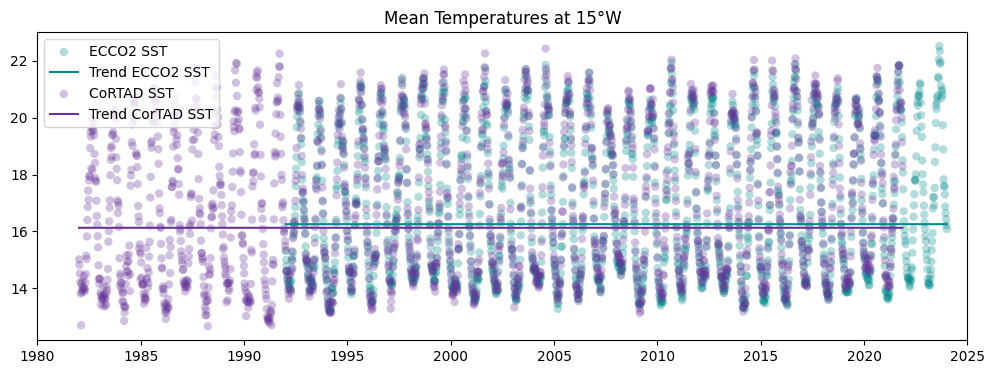

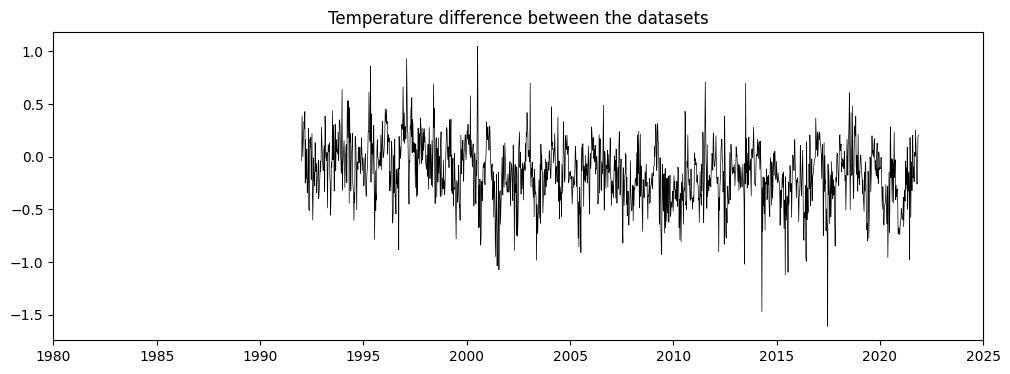

In [6]:
## calculate trend
ECCO2_trend = ECCO2.SST_mean.polyfit(dim = 'time', deg = 1)
UI_SST_trend = UI_SST.Toff15W_mean.polyfit(dim = 'time', deg = 1)

# plot
fig = plt.figure(figsize = (12,4))
# ECCO2
plt.scatter(ECCO2.time, ECCO2.SST_mean, color = 'darkcyan', alpha = 0.3, edgecolors = 'none', label = 'ECCO2 SST')
plt.plot(ECCO2.time, np.arange(0, len(ECCO2.time)) *  ECCO2_trend.polyfit_coefficients.sel(degree = 1).values + ECCO2_trend.polyfit_coefficients.sel(degree = 0).values,
        color = 'darkcyan', label = 'Trend ECCO2 SST')
# CoRTAD / UI SST
plt.scatter(UI_SST.time, UI_SST.Toff15W_mean, color = 'rebeccapurple', alpha = 0.3, edgecolors = 'none', label = 'CoRTAD SST')
plt.plot(UI_SST.time, np.arange(0, len(UI_SST.time)) *  UI_SST_trend.polyfit_coefficients.sel(degree = 1).values + UI_SST_trend.polyfit_coefficients.sel(degree = 0).values,
        color = 'rebeccapurple', label = 'Trend CorTAD SST')
plt.xlim(dt.date(1980,1,1), dt.date(2025,1,1))
plt.title('Mean Temperatures at 15°W')
plt.legend()

## difference between the two 
fig = plt.figure(figsize = (12,4))
diff_time = ECCO2.time.where(ECCO2.time == UI_SST.time, drop = True)
diff_T = ECCO2.SST_mean.where(ECCO2.time == UI_SST.time, drop = True) - UI_SST.Toff15W_mean.where(ECCO2.time == UI_SST.time, drop = True)
plt.xlim(dt.date(1980,1,1), dt.date(2025,1,1))
plt.plot(diff_time, diff_T, color = 'k', linewidth = 0.5) #, edgecolors = 'none')
plt.title('Temperature difference between the datasets')

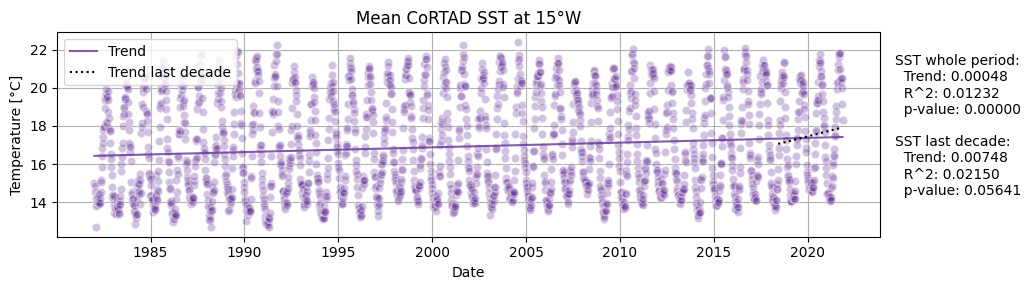

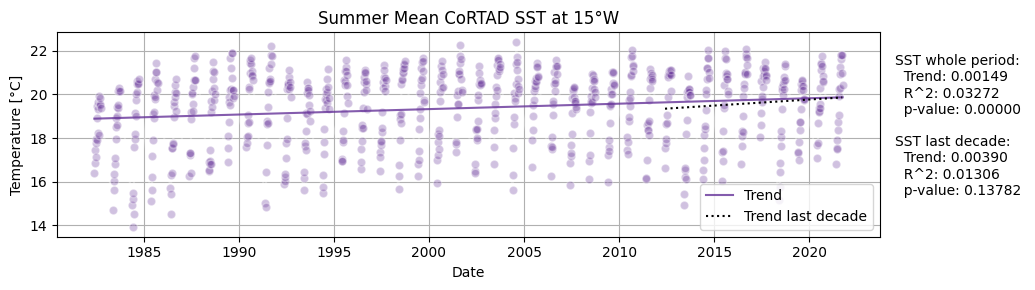

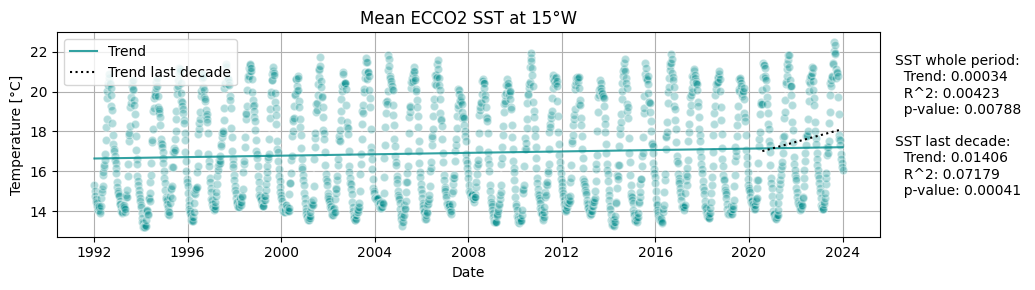

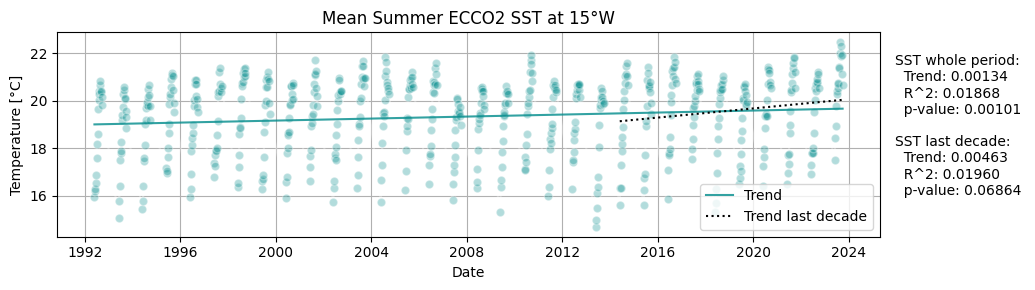

In [7]:
# get values for the trend line analysis

for i in np.arange(0, 4):

    # variables
    if i == 0:
        x_dates = UI_SST.time
        y = UI_SST.Toff15W_mean
        title = 'Mean CoRTAD SST at 15°W'
        color = 'rebeccapurple'
    if i == 1:
        x_dates = UI_SST_summer.time
        y = UI_SST_summer.Toff15W_mean
        title = 'Summer Mean CoRTAD SST at 15°W'
    if i == 2:
        x_dates = ECCO2.time
        y = ECCO2.SST_mean
        title = 'Mean ECCO2 SST at 15°W'
        color = 'darkcyan'
    if i == 3:
        x_dates = ECCO2_summer.time
        y = ECCO2_summer.SST_mean
        title = 'Mean Summer ECCO2 SST at 15°W' 
        
    # start plot
    fig = plt.figure(figsize = (9, 3))
    
    x_num = dates.date2num(x_dates)
    x_num_10 = x_num[-180:-1]
    
    # calculate a fit line
    trend = np.polyfit(x_num, y, 1)
    fit = np.poly1d(trend)
    
    # calculate fitline only for past decade
    trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
    fit_10 = np.poly1d(trend_10)
    
    # general plot 
    plt.plot(x_dates, y, marker = 'o', markerfacecolor = color, alpha = 0.3, color = 'white')
    plt.xlabel('Date')
    plt.ylabel(r'Temperature [°C]')
    
    # get the input numbers for the fit line and convert the numbers back to dates
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.plot(dates.num2date(x_fit), fit(x_fit), color = color, linestyle = "-" , alpha = 0.8, label = 'Trend')
    
    # last 10 years
    x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
    plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 
    
    plt.legend()
    plt.grid()
    plt.title(title)
    
    ## UI_SST whole period
    time = np.arange(0, len(x_dates))
    values = y.values
    time_with_const = sm.add_constant(time)
    model_full = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    ## UI_SST last decace
    time = np.arange(0, len(x_dates.isel(time = slice(-170, None))))
    values = y.isel(time = slice(-170, None)).values
    time_with_const = sm.add_constant(time)
    model_10 = sm.OLS(values, time_with_const).fit()   ## OLS -> ordinary least squares
    
    plt.figtext(1, 0.28, f'SST whole period: \n  Trend: {model_full.params[1]:.5f} \n  R^2: {model_full.rsquared:.5f} \n  p-value: {model_full.pvalues[1]:.5f} \n\nSST last decade: \n  Trend: {model_10.params[1]:.5f} \n  R^2: {model_10.rsquared:.5f} \n  p-value: {model_10.pvalues[1]:.5f} \n')
    
    fig.tight_layout()
    # fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Trend_SST.png', dpi = 300, bbox_inches='tight')

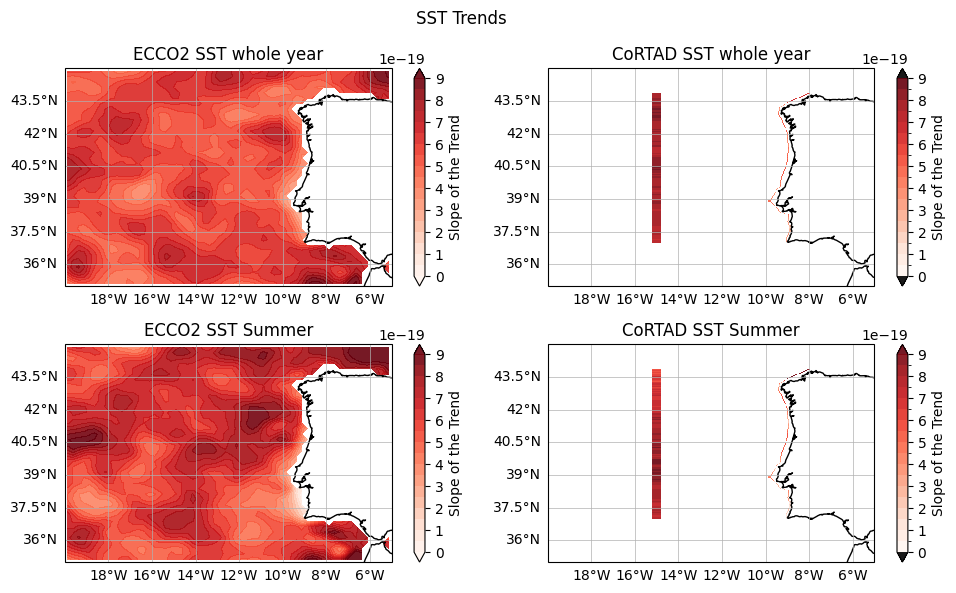

In [8]:
# https://stackoverflow.com/questions/70767908/calculate-linear-trend-in-each-grid-cell
xsize = 2
ysize = 2
fig, axs = plt.subplots(xsize, ysize, figsize = (10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

Vars = [ECCO2.SST, ECCO2_summer.SST, UI_SST.Toff15W, UI_SST_summer.Toff15W, UI_SST.Tmid, UI_SST_summer.Tmid]
title = ['ECCO2 SST whole year', 'ECCO2 SST Summer', 'CoRTAD SST whole year', 'CoRTAD SST Summer']
i = 0
for x in np.arange(0, xsize):
    for y in np.arange(0, ysize):
        
        ax = axs[y,x]
        
        # set up cartopy
        ax.set_extent([-20, -5, 45, 35])
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
        gls.top_labels = False 
        gls.right_labels = False
            
        if i <= 1: 

            DS = Vars[i]
            result = DS.polyfit(dim = "time", deg = 1)

            im = ax.contourf(result.lon, result.lat, result.polyfit_coefficients.sel(degree=1), 
                         cmap = 'Reds', extend = 'both', levels = np.arange(0, 9.5e-19, 0.5e-19), alpha = 0.9)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend')
            
        if i > 1 :

            # Toff15W
            DS = Vars[i]
            result = DS.polyfit(dim = "time", deg = 1)
            
            im = result.polyfit_coefficients.sel(lon = slice(-20, -5)).sel(degree=1).plot(ax = ax, x = 'lon',
                         cmap = 'Reds', levels = np.arange(0, 9.5e-19, 0.5e-19), alpha = 0.9, add_colorbar=False)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend', extend = 'both')
            # add patches to focus on 15°W (otherwise plot shows wider strip from ~18°w to ~8°W)
            ax.add_patch(mpatches.Rectangle(xy=[-18, 36], width = 2.8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))
            ax.add_patch(mpatches.Rectangle(xy=[-14.8, 36], width = 8, height = 8, facecolor = 'white', transform = ccrs.PlateCarree()))

            # Tmid
            DS = Vars[i + 2]
            result = DS.polyfit(dim = "time", deg = 1)

            im = result.polyfit_coefficients.sel(lon = slice(-20, -5)).sel(degree=1).plot(ax = ax, x = 'lon',
                         cmap = 'Reds', levels = np.arange(0, 9.5e-19, 0.5e-19), alpha = 0.9, add_colorbar=False)  
            
    
        ax.set_title(f'{title[i]}')

        i = i+1
    fig.suptitle('SST Trends')
    fig.tight_layout()

fig.savefig('../Iberian_Coast_Upwelling/Figures/SST_trends.png', dpi = 300)